In [1]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from scipy.stats import gaussian_kde
sns.set_style("white")
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import scipy.stats as st
from sklearn.utils import resample
%matplotlib inline

In [2]:
means = [-2, 0 , 1]
stds = [.2, .2, .4]
d = 1  # dimension

def scott_rule_of_thumb(n, d):
    return n**(-1./(d+4))


def silverman_rule_of_thumb(n, d):
    return (n * (d + 2) / 4.)**(-1. / (d + 4))


def make_data(nobs):
    data = []
    sp.random.seed(42)
    for _ in range(nobs):
        c = sp.random.randint(len(means))
        data.append(st.norm(loc=means[c], scale=stds[c]).rvs())

    data = sp.array(data)[:,None]
    return data

def fit_kde(data):
    params = {'bandwidth': np.logspace(-2, 0, 20)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)
    kde = grid.best_estimator_
    return kde, grid

def gt_pdf(x):
    return sum(st.norm(loc=m, scale=s).pdf(x)
               for m,s in zip(means, stds)) / len(means)

boot_strap_method = "scott"
def bootstrapped_mean_coefficient_of_variation(data, method=boot_strap_method):
    nr_bootstrap_points = data.size
    nr_bootstrap = 10
    boot_strapped_samples = [resample(data, n_samples=nr_bootstrap_points) for _ in range(nr_bootstrap)]
    fitted_kdes = list(map(lambda x: gaussian_kde(x.flatten(), bw_method=method), boot_strapped_samples))
    vals = sp.array(list(map(lambda kde: kde.pdf(data.flatten()), fitted_kdes)))
    return st.variation(vals,0), fitted_kdes

In [3]:
plot_nobs = [10, 50 , 200, 1000, 2000]
plot_data = list(map(make_data, plot_nobs))
plot_kde = list(map(fit_kde, plot_data))
plot_coeff_var = list(map(bootstrapped_mean_coefficient_of_variation, plot_data))
plot_mean_coeff_var = list(map(lambda x: sp.mean(x[0]), plot_coeff_var))

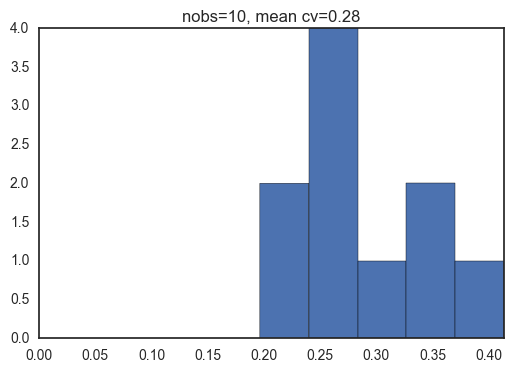

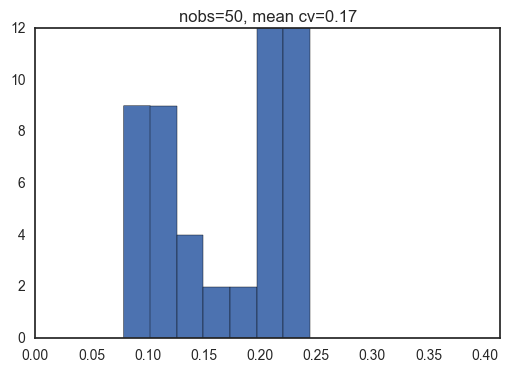

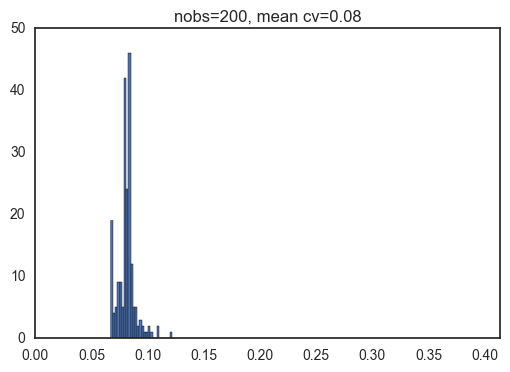

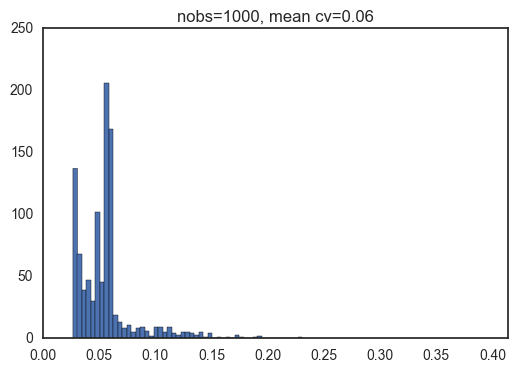

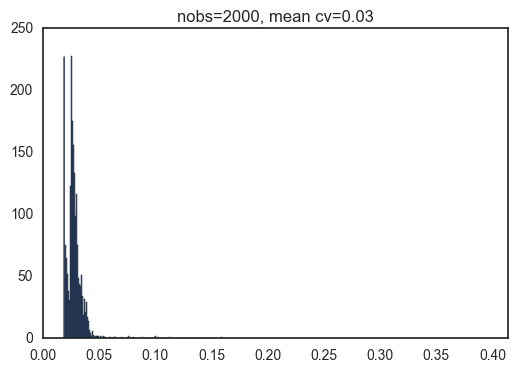

In [4]:
for nobs, (coeff_var, kdes), mean_c in zip(plot_nobs, plot_coeff_var, plot_mean_coeff_var):
    plt.hist(coeff_var, bins="auto");
    plt.xlim(0, max(map(lambda x: max(x[0]), plot_coeff_var)))
    plt.title("nobs={}, mean cv={:.2f}".format(nobs, mean_c))
    plt.show()

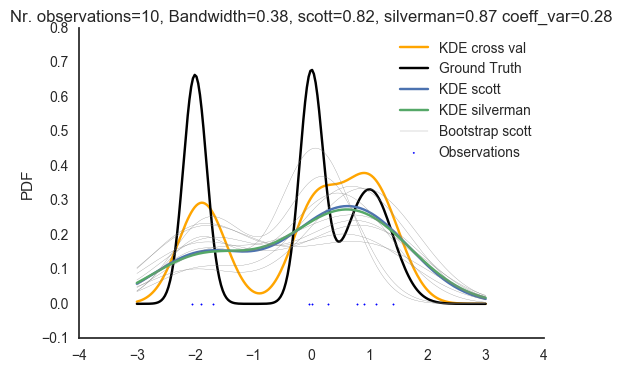

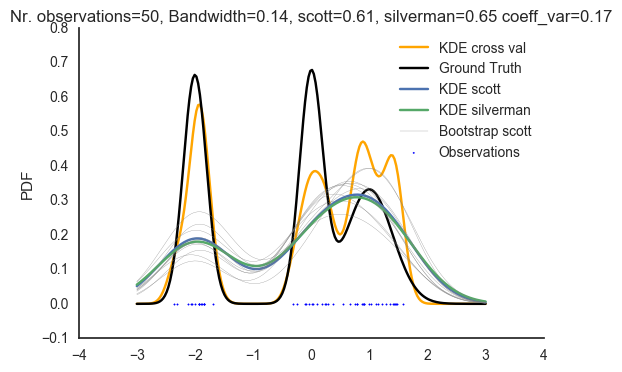

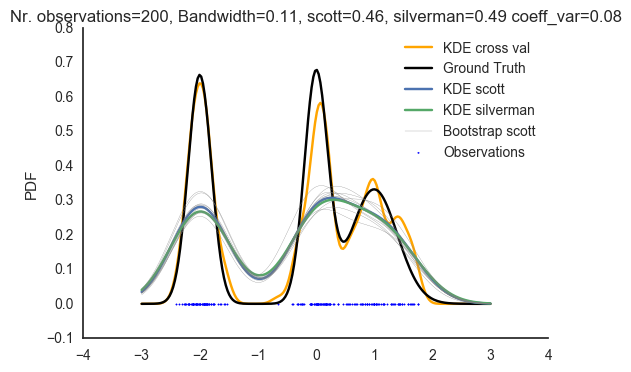

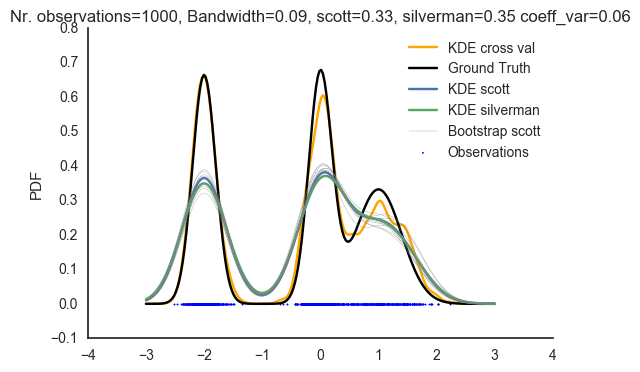

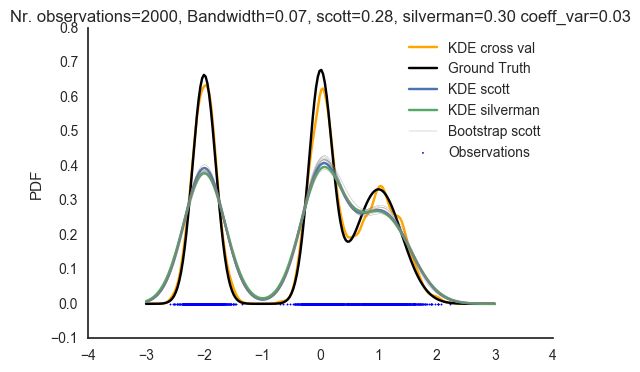

In [5]:
for nobs, data, (kde, grid), mean_coeff_var, (coeff_var, cv_kdes) in zip(plot_nobs, plot_data,
                                                   plot_kde, plot_mean_coeff_var, plot_coeff_var):
    h_scott = scott_rule_of_thumb(nobs, 1)
    h_silver = silverman_rule_of_thumb(nobs, 1)
    test = sp.linspace(-3,3, 200)[:,None]
    pdf = kde.score_samples(test)
    plt.plot(test, sp.exp(pdf), label="KDE cross val", color="orange")
    plt.plot(test, gt_pdf(test), label="Ground Truth", color="k")
    scale_bar_x_offset = 2
    scale_bar_y = .4
    
    g_kde_h = {}
    for method in ["scott", "silverman"]:
        g_kde = gaussian_kde(data.flatten(), bw_method=method)
        g_kde_h[method] = sp.sqrt(g_kde.covariance)
        plt.plot(test, g_kde.pdf(test.flatten()), label="KDE " + method)
        
    label = "Bootstrap " + boot_strap_method
    for k in cv_kdes:
        plt.plot(test, k.pdf(test.flatten()), color="grey", linewidth=.2, label=label)
        label = None
    
    #plt.plot([0+ scale_bar_x_offset, kde.bandwidth+ scale_bar_x_offset],
    #         [scale_bar_y,scale_bar_y],
    #         color="k", linewidth=10, solid_capstyle="butt")
    plt.scatter(data.flatten(), sp.zeros(data.size), color="blue", s=1, label="Observations")
    #plt.text(scale_bar_x_offset,scale_bar_y+.02,"Bandwidth", va="bottom")
    plt.title("Nr. observations={}, Bandwidth={:.2f}, scott={:.2f}, silverman={:.2f}"
              " coeff_var={:.2f}".format(nobs, kde.bandwidth, float(g_kde_h["scott"]),
                                        float(g_kde_h["silverman"]), float(mean_coeff_var)))
    plt.legend()
    plt.ylabel("PDF")
    sns.despine(ax=plt.gca())
    plt.show()
    

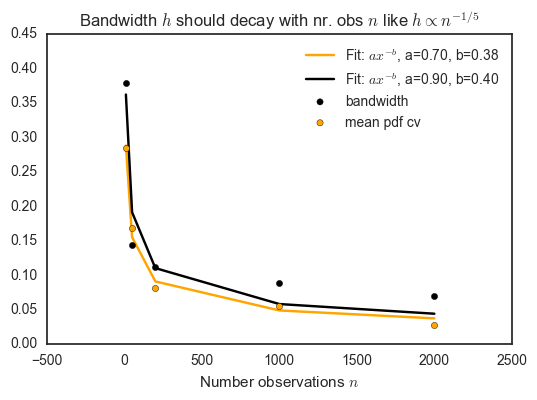

In [6]:
bandwidths = [kde[0].bandwidth for kde in plot_kde]
plt.scatter(plot_nobs, bandwidths, c="k", label="bandwidth");
plt.scatter(plot_nobs, plot_mean_coeff_var, c="orange", label="mean pdf cv");
plt.xlabel("Number observations $n$");
plt.title("Bandwidth $h$ should decay with nr. obs $n$ like $h \propto n^{-1/5}$");

from scipy.optimize import curve_fit
def fitpowerlaw(x, y):
    x = np.array(x)
    y = np.array(y)
    
    def f(x, a, b):
        return a * x **(-b)
    
    popt, cov = curve_fit(f, x, y, p0=[.5, 1/5])
    
    return popt, lambda x: f(x, *popt)

popt, f = fitpowerlaw(plot_nobs, plot_mean_coeff_var)
plt.plot(plot_nobs, f(plot_nobs),
         label="Fit: $a x ^{{-b}}$, a={:.2f}, b={:.2f}".format(*popt),
         c="orange", zorder=-20)

popth, fh = fitpowerlaw(plot_nobs, bandwidths)
plt.plot(plot_nobs, fh(plot_nobs),
         label="Fit: $a x ^{{-b}}$, a={:.2f}, b={:.2f}".format(*popth),
         c="k", zorder=-20)

plt.legend();